# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

## Step 1: Read in Data

In [1]:
import pandas as pd  # import the neccessary libraries
pd.set_option('display.max_columns', 300)  # display all the columns
pd.set_option('display.max_rows', 100)
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor  # In case we want to use k-nearest neighbor model
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn')
sns.set(style="white")

In [2]:
house = pd.read_csv('kc_house_data_train.csv')  # read in the csv file with train data
print(house.shape)  # check the dimensions of the model
house.head()  # print the first 5 rows

(17290, 22)


,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [3]:
house.dtypes  # check the column types

Unnamed: 0         int64
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [4]:
house.zipcode.nunique(dropna=False)

70

In [5]:
house.grade.value_counts(normalize=True)

7     0.415442
8     0.280393
9     0.121400
6     0.095315
10    0.051648
11    0.018450
5     0.011105
12    0.004164
4     0.001272
13    0.000636
3     0.000116
1     0.000058
Name: grade, dtype: float64

In [6]:
price_by_zip = house.groupby('zipcode')['price'].mean()

In [7]:
price_by_zip.sort_values()

zipcode
98002    2.322865e+05
98168    2.410415e+05
98032    2.516022e+05
98148    2.720823e+05
98001    2.819988e+05
98188    2.890318e+05
98023    2.895726e+05
98003    2.907627e+05
98030    2.964029e+05
98031    3.005987e+05
98198    3.051785e+05
98055    3.068521e+05
98022    3.087681e+05
98042    3.091687e+05
98178    3.126811e+05
98106    3.183727e+05
98092    3.397201e+05
98058    3.543642e+05
98108    3.560812e+05
98146    3.637469e+05
98038    3.684230e+05
98133    3.863916e+05
98118    4.117730e+05
98155    4.229997e+05
98056    4.234974e+05
98010    4.248736e+05
98126    4.250761e+05
98019    4.284222e+05
98045    4.313185e+05
98014    4.562057e+05
98028    4.684170e+05
98125    4.752226e+05
98166    4.793758e+05
98011    4.906393e+05
98059    4.943730e+05
98070    4.956727e+05
98034    5.238643e+05
98065    5.272174e+05
98136    5.659156e+05
98072    5.667307e+05
98117    5.701880e+05
98107    5.834824e+05
98103    5.897893e+05
98024    5.909915e+05
98007    5.975536e+05
98

In [8]:
zip_category = pd.cut(price_by_zip, bins =[0,350000,600000,900000,3500000], labels = ['low','medium','high','very_high'])
zip_category.to_csv('zip_cat.csv')

In [9]:
house['zip_price_level'] = house['zipcode'].apply(lambda x: zip_category.loc[x])
house['zip_price_level'].value_counts()

medium       7301
high         5415
low          3770
very_high     804
Name: zip_price_level, dtype: int64

In [10]:
house = pd.get_dummies(house, columns = ['zip_price_level'], drop_first= True)
house.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,zip_price_level_low,zip_price_level_medium,zip_price_level_very_high
0,0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,0,1,0
1,1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,0,0,0
2,2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,0,0,0
3,3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,0,1,0
4,4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,0,0,0


## Step 2: Exploratory Data Analysis 
    
Become familiar with the data.  Look to see if there are any extreme values.  

Additionally create data visualizations to determine if there are any relationships between your features and your target variables.

* Not all the id values are unique. Are there houses that were sold multiple times? Let's check out some of these entries and see what's going on.

In [11]:
house[(house['id'] == 1232000810) | (house['id'] == 3558900590)]

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,zip_price_level_low,zip_price_level_medium,zip_price_level_very_high
7491,7491,1232000810,20140912T000000,340000.0,3,2.50,1400,4800,1.0,0,0,3,7,1200,200,1921,0,98117,47.6865,-122.379,1440,3840,0,1,0
11136,11136,1232000810,20150326T000000,537000.0,3,2.50,1400,4800,1.0,0,0,3,7,1200,200,1921,0,98117,47.6865,-122.379,1440,3840,0,1,0
12664,12664,3558900590,20150324T000000,692500.0,6,1.75,2230,10080,1.0,0,0,3,7,1390,840,1969,0,98034,47.7089,-122.201,2110,8475,0,1,0
16139,16139,3558900590,20141125T000000,360000.0,6,1.75,2230,10080,1.0,0,0,3,7,1390,840,1969,0,98034,47.7089,-122.201,2110,8475,0,1,0


* From this, we can conclude that some house were sold multiple times for different prices. Therefore, the **date** a house is sold is related to the price

In [12]:
house.isnull().sum().any() # check if there are any null values

False

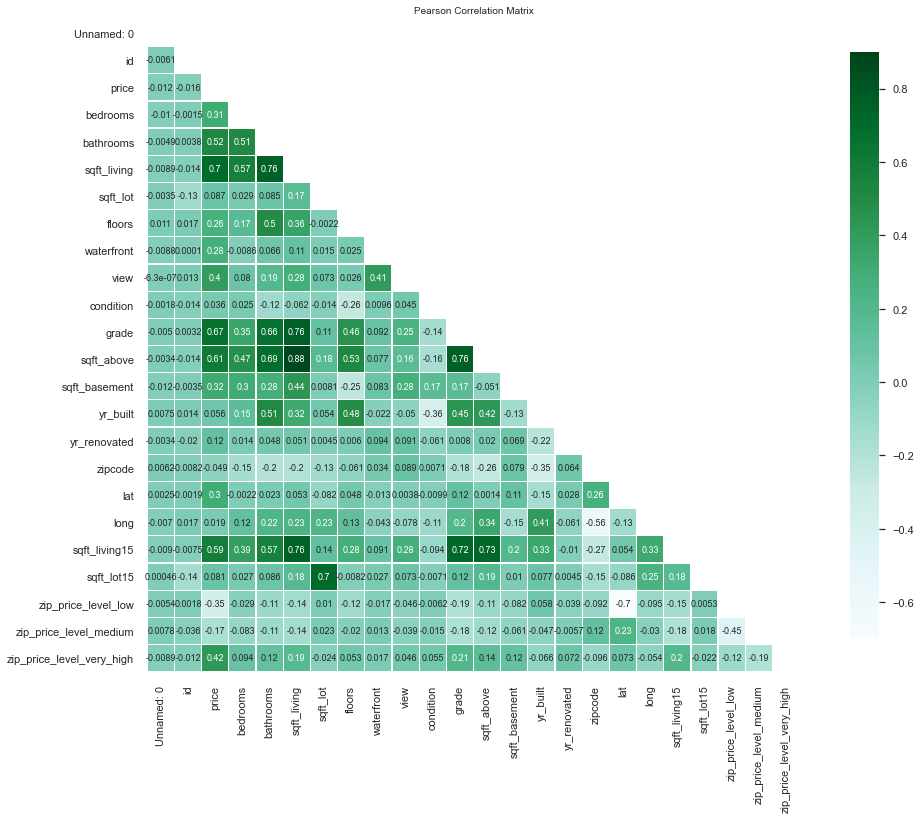

In [12]:
# let's check the correlation between the features

mask = np.zeros_like(house.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(18, 12))
plt.title('Pearson Correlation Matrix',fontsize=10)

sns.heatmap(house.corr(),linewidths=0.25,vmax=0.9,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});
plt.show()

* we may be able to drop `sqft_living15` since it is highly correlated with **grade** and **sqft_above**
* `sqft_lot15` has high correlation with **sqft_lot** and very low correlation with **price**

## Step 3: Clean up any issues with the data like extreme values.  

remember that you can't just delete rows with extreme values. Similar observations might be present in the holdout dataset, and you can't just delete those rows and not have a prediction for it. 

## Step 4: Generate new features that you think could be important

After doing this, you will want to go back to steps 2 and 3 to investigates these new features

In [13]:
# transform 'yr_built' column to a column that tells us how old a house is
house['yrs_old'] = 2016 - house['yr_built']  # create new column to store this data
house.yrs_old.describe()

count    17290.000000
mean        45.207981
std         29.343516
min          1.000000
25%         20.000000
50%         42.000000
75%         65.000000
max        116.000000
Name: yrs_old, dtype: float64

In [14]:
house[house.yr_renovated == 0]['yr_renovated'].count()  # check how many houses have not been renovated

16564

Many houses have not been renovated. Therefore, we can consider turning this into a boolean column.

### 4.1) Identify a categorical variable in the data set and create dummy columns.

In [15]:
# If a house has been renovated assign 1, if not assign 0
house['renovated'] = house['yr_renovated'].apply(lambda x: (1 if  x > 0 else 0))
house.renovated.value_counts()

0    16564
1      726
Name: renovated, dtype: int64

### 4.2) There is a column that gives the date for when the house was sold, how could this be useful in your model? How might you transform the current column to a more useful feature?

In [16]:
house['year_sold'] = house['date'].str[0:4].astype(int)  # create a column to check when these houses were sold

In [17]:
house.year_sold.unique()  # check which years these houses have been sold

array([2014, 2015])

In [18]:
house.groupby('year_sold')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
year_sold,,,,,,,,
2014,11703.0,541341.601299,377104.805515,78000.0,320000.0,450000.0,650000.0,7700000.0
2015,5587.0,539478.438518,365291.881178,75000.0,325000.0,450000.0,637000.0,5350000.0


This dataset contains only two years of sales data. There isn't much of a difference in price statistics between btoh years.

In [19]:
house['month_sold'] = house['date'].str[4:6].astype(int) # create a column to check what month houses were sold

In [20]:
# create a new interaction feature by adding 'bedrooms' and 'bathrooms' columns
house['bed_bath'] = house['bedrooms'] + house['bathrooms']

In [21]:
np.abs(house.corr()['price'])  # lets check possible feature correlations with the price column

Unnamed: 0                   0.012306
id                           0.015644
price                        1.000000
bedrooms                     0.305106
bathrooms                    0.524335
sqft_living                  0.703540
sqft_lot                     0.086803
floors                       0.256985
waterfront                   0.275779
view                         0.395485
condition                    0.036099
grade                        0.666215
sqft_above                   0.607760
sqft_basement                0.323312
yr_built                     0.056450
yr_renovated                 0.117770
zipcode                      0.048958
lat                          0.302394
long                         0.019327
sqft_living15                0.585567
sqft_lot15                   0.081423
zip_price_level_low          0.346408
zip_price_level_medium       0.165062
zip_price_level_very_high    0.423978
yrs_old                      0.056450
renovated                    0.117409
year_sold   

`sqft_lot`,`condition`,`sqft_lot15`,`year_sold`,`yrs_old` seem to have very little correlation with the target column.

In [22]:
features =['sqft_living','floors','waterfront','view','grade','bed_bath','renovated','yrs_old',
          'sqft_lot15','sqft_living15','condition','zip_price_level_low','zip_price_level_medium',
           'zip_price_level_very_high']
df = house[features].copy()
df['price'] = house['price']

In [23]:
df_scaled = (df - df.mean())/df.std()

In [24]:
df_scaled['price'] = df['price']

In [25]:
df_scaled.head()

,sqft_living,floors,waterfront,view,grade,bed_bath,renovated,yrs_old,sqft_lot15,sqft_living15,condition,zip_price_level_low,zip_price_level_medium,zip_price_level_very_high,price
0,-0.012461,0.945776,-0.089695,-0.307676,0.294177,0.514857,-0.20935,-0.518274,-0.190010,0.587050,0.908187,-0.528044,1.169654,-0.22083,365000.0
1,0.889694,-0.909823,-0.089695,-0.307676,0.294177,1.691733,-0.20935,-0.211562,-0.242053,0.557844,2.443588,-0.528044,-0.854905,-0.22083,865000.0
2,1.835328,0.945776,-0.089695,2.272207,2.847981,0.682983,-0.20935,-0.893144,-0.117105,2.514613,-0.627215,-0.528044,-0.854905,-0.22083,1038000.0
3,2.694006,0.945776,-0.089695,2.272207,3.699249,0.682983,-0.20935,-0.654590,0.049675,3.011106,-0.627215,-0.528044,1.169654,-0.22083,1490000.0
4,0.509267,0.945776,-0.089695,-0.307676,1.145445,0.010482,-0.20935,-1.131697,-0.324066,0.382611,-0.627215,-0.528044,-0.854905,-0.22083,711000.0


In [26]:
from statsmodels.formula.api import ols

lr_model = ols(formula='price~sqft_living+floors+grade+waterfront+yrs_old+renovated+view', 
               data=df_scaled).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     4456.
Date:                Tue, 08 Sep 2020   Prob (F-statistic):               0.00
Time:                        13:44:29   Log-Likelihood:            -2.3745e+05
No. Observations:               17290   AIC:                         4.749e+05
Df Residuals:                   17282   BIC:                         4.750e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    5.407e+05   1695.590    318.909      0.000    5.37e+05    5.44e+05
sqft_living  1.549e+05   2657.706     58.278      0.000     1.5e+05     1.6e+05
floors       1.676e+04   2051.189      8.173      0.000    1.27e+04    2.08e+04
grade         1.54e+05   2859.499     53.868      0.000    1.48e+05     1.6e+05
waterfront   5.337e+04   1861.287     28.674      0.000    4.97e+04     5.7e+04
yrs_old      1.017e+05   2125.395     47.848      0.000    9.75e+04    1.06e+05
renovated    3455.6442   1770.283      1.952      0.051     -14.290    6925.578
view         3.777e+04   1958.456     19.287      0.000    3.39e+04    4.16e+04
==============================================================================
Omnibus:                    13812.734   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1166720.089
Skew:                           3.267   Prob(JB):                         0.00
Kurtosis:                      42.709   Cond. No.                         3.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Step 5: Train Test Split

If you plan on doing any sclaing of your data, make sure it is doen at the apporpriate time. 

### 5.1) Perform a train test split of the data.

In [27]:
df_features = house[features]

target = house['price']

In [28]:
df_features.isnull().mean()

sqft_living                  0.0
floors                       0.0
waterfront                   0.0
view                         0.0
grade                        0.0
bed_bath                     0.0
renovated                    0.0
yrs_old                      0.0
sqft_lot15                   0.0
sqft_living15                0.0
condition                    0.0
zip_price_level_low          0.0
zip_price_level_medium       0.0
zip_price_level_very_high    0.0
dtype: float64

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=9,test_size=0.25)

In [30]:
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

#transform the training data
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=df_features.columns)

#transform the testing data
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=df_features.columns)

In [31]:
#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train, y_train)

y_train_pred = lm.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 186412.89161703794


### Evaluate on the test set

In [32]:
#use fitted model to predict on the test examples
y_test_pred = lm.predict(X_test)

#evaluate the predictions on the test examples
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print('Testing Root Mean Squared Error:' , test_rmse)
print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Testing Root Mean Squared Error: 187694.88588205332
Training:  186412 vs. Testing:  187694


## Generate Polynomial and Interaction features


In [33]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(df_features)
poly2_columns = poly_2.get_feature_names(df_features.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
print(df_poly2.shape)
df_poly2.head()

(17290, 119)


,sqft_living,floors,waterfront,view,grade,bed_bath,renovated,yrs_old,sqft_lot15,sqft_living15,condition,zip_price_level_low,zip_price_level_medium,zip_price_level_very_high,sqft_living^2,sqft_living floors,sqft_living waterfront,sqft_living view,sqft_living grade,sqft_living bed_bath,sqft_living renovated,sqft_living yrs_old,sqft_living sqft_lot15,sqft_living sqft_living15,sqft_living condition,sqft_living zip_price_level_low,sqft_living zip_price_level_medium,sqft_living zip_price_level_very_high,floors^2,floors waterfront,floors view,floors grade,floors bed_bath,floors renovated,floors yrs_old,floors sqft_lot15,floors sqft_living15,floors condition,floors zip_price_level_low,floors zip_price_level_medium,floors zip_price_level_very_high,waterfront^2,waterfront view,waterfront grade,waterfront bed_bath,waterfront renovated,waterfront yrs_old,waterfront sqft_lot15,waterfront sqft_living15,waterfront condition,waterfront zip_price_level_low,waterfront zip_price_level_medium,waterfront zip_price_level_very_high,view^2,view grade,view bed_bath,view renovated,view yrs_old,view sqft_lot15,view sqft_living15,view condition,view zip_price_level_low,view zip_price_level_medium,view zip_price_level_very_high,grade^2,grade bed_bath,grade renovated,grade yrs_old,grade sqft_lot15,grade sqft_living15,grade condition,grade zip_price_level_low,grade zip_price_level_medium,grade zip_price_level_very_high,bed_bath^2,bed_bath renovated,bed_bath yrs_old,bed_bath sqft_lot15,bed_bath sqft_living15,bed_bath condition,bed_bath zip_price_level_low,bed_bath zip_price_level_medium,bed_bath zip_price_level_very_high,renovated^2,renovated yrs_old,renovated sqft_lot15,renovated sqft_living15,renovated condition,renovated zip_price_level_low,renovated zip_price_level_medium,renovated zip_price_level_very_high,yrs_old^2,yrs_old sqft_lot15,yrs_old sqft_living15,yrs_old condition,yrs_old zip_price_level_low,yrs_old zip_price_level_medium,yrs_old zip_price_level_very_high,sqft_lot15^2,sqft_lot15 sqft_living15,sqft_lot15 condition,sqft_lot15 zip_price_level_low,sqft_lot15 zip_price_level_medium,sqft_lot15 zip_price_level_very_high,sqft_living15^2,sqft_living15 condition,sqft_living15 zip_price_level_low,sqft_living15 zip_price_level_medium,sqft_living15 zip_price_level_very_high,condition^2,condition zip_price_level_low,condition zip_price_level_medium,condition zip_price_level_very_high,zip_price_level_low^2,zip_price_level_low zip_price_level_medium,zip_price_level_low zip_price_level_very_high,zip_price_level_medium^2,zip_price_level_medium zip_price_level_very_high,zip_price_level_very_high^2
0,2070.0,2.0,0.0,0.0,8.0,6.25,0.0,30.0,7700.0,2390.0,4.0,0.0,1.0,0.0,4284900.0,4140.0,0.0,0.0,16560.0,12937.5,0.0,62100.0,15939000.0,4947300.0,8280.0,0.0,2070.0,0.0,4.0,0.0,0.0,16.0,12.5,0.0,60.0,15400.0,4780.0,8.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,50.0,0.0,240.0,61600.0,19120.0,32.0,0.0,8.0,0.0,39.0625,0.0,187.5,48125.0,14937.5,25.0,0.0,6.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,900.0,231000.0,71700.0,120.0,0.0,30.0,0.0,59290000.0,18403000.0,30800.0,0.0,7700.0,0.0,5712100.0,9560.0,0.0,2390.0,0.0,16.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2900.0,1.0,0.0,0.0,8.0,8.00,0.0,39.0,6283.0,2370.0,5.0,0.0,0.0,0.0,8410000.0,2900.0,0.0,0.0,23200.0,23200.0,0.0,113100.0,18220700.0,6873000.0,14500.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,8.0,0.0,39.0,6283.0,2370.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,64.0,0.0,312.0,50264.0,18960.0,40.0,0.0,0.0,0.0,64.0000,0.0,312.0,50264.0,18960.0,40.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1521.0,245037.0,92430.0,195.0,0.0,0.0,0.0,39476089.0,14890710.0,31415.0,0.0,0.0,0.0,5616900.0,11850.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3770.0,2.0,0.0,2.0,11.0,6.50,0.0,19.0,9685.0,3710.0,3.0,0.0,0.0,0.0,14212900.0,7540.0,0.0,7540.0,41470.0,24505.0,0.0,71630.0,36512450.0,13986700.0,11310.0,0.0,0.0,0.0

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df_poly2, target, random_state=9,test_size=0.2)

In [35]:
scaler2 = StandardScaler()
# fit the scaler to the training data
scaler2.fit(X_train)

#transform the training data
X_train = pd.DataFrame(data=scaler2.transform(X_train), columns=df_poly2.columns)

#transform the testing dat
X_test = pd.DataFrame(data=scaler2.transform(X_test), columns=df_poly2.columns)

In [36]:
# instantiate a linear regression object
lm_2 = LinearRegression()

#fit the linear regression to the data
lm_2 = lm_2.fit(X_train, y_train)

y_train_pred = lm_2.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 144854.8314663832


In [37]:
y_pred = lm_2.predict(X_test)

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Testing Root Mean Squared Error:' , test_rmse)
print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Testing Root Mean Squared Error: 148302.09781539813
Training:  144854 vs. Testing:  148302


## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models

### 6.1) Utilize a filter method to identify some features to remove from the model.  


In [38]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1, normalize=False)

lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)

train_rmse_lasso01 = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse_lasso01 = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse_lasso01) )
print('Testing Error: '+ str(test_rmse_lasso01) )

Training Error: 90026.48338494527
Testing Error: 148651.45145957498


/Users/farhan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145138108587863.4, tolerance: 194982925380.51126
  model = cd_fast.enet_coordinate_descent(


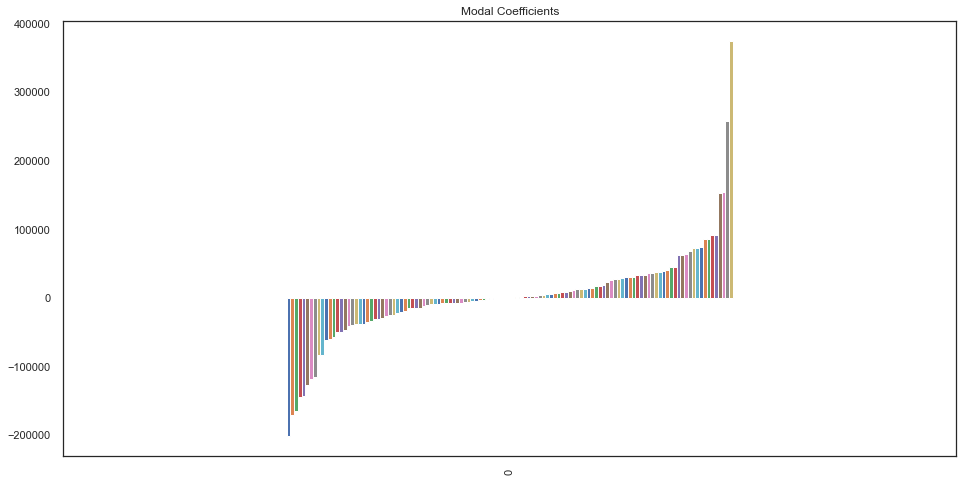

In [39]:
lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))

In [40]:
print('Original: \t', test_rmse, '\n',
      "Lasso 0.01: \t",  test_rmse_lasso01, '\n')

Original: 	 148302.09781539813 
 Lasso 0.01: 	 148651.45145957498 



In [41]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

selector = SelectKBest(f_regression, k=20)

selector.fit(X_train, y_train)

/Users/farhan/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/farhan/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


SelectKBest(k=20, score_func=<function f_regression at 0x7f924c5cb430>)

In [42]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [43]:
list(removed_columns)

['floors',
 'waterfront',
 'view',
 'bed_bath',
 'renovated',
 'yrs_old',
 'sqft_lot15',
 'condition',
 'zip_price_level_low',
 'zip_price_level_medium',
 'zip_price_level_very_high',
 'sqft_living waterfront',
 'sqft_living renovated',
 'sqft_living yrs_old',
 'sqft_living sqft_lot15',
 'sqft_living zip_price_level_low',
 'sqft_living zip_price_level_medium',
 'floors^2',
 'floors waterfront',
 'floors view',
 'floors grade',
 'floors bed_bath',
 'floors renovated',
 'floors yrs_old',
 'floors sqft_lot15',
 'floors condition',
 'floors zip_price_level_low',
 'floors zip_price_level_medium',
 'floors zip_price_level_very_high',
 'waterfront^2',
 'waterfront view',
 'waterfront grade',
 'waterfront bed_bath',
 'waterfront renovated',
 'waterfront yrs_old',
 'waterfront sqft_lot15',
 'waterfront sqft_living15',
 'waterfront condition',
 'waterfront zip_price_level_low',
 'waterfront zip_price_level_medium',
 'waterfront zip_price_level_very_high',
 'view^2',
 'view grade',
 'view bed_bat

In [44]:
list(selected_columns)

['sqft_living',
 'grade',
 'sqft_living15',
 'sqft_living^2',
 'sqft_living floors',
 'sqft_living view',
 'sqft_living grade',
 'sqft_living bed_bath',
 'sqft_living sqft_living15',
 'sqft_living condition',
 'sqft_living zip_price_level_very_high',
 'floors sqft_living15',
 'grade^2',
 'grade bed_bath',
 'grade sqft_living15',
 'grade condition',
 'bed_bath sqft_living15',
 'sqft_living15^2',
 'sqft_living15 condition',
 'sqft_living15 zip_price_level_very_high']

In [45]:
lm_kbest = LinearRegression()

#fit the linear regression to the data
lm_kbest = lm_kbest.fit(X_train[selected_columns], y_train)

y_train_kbest = lm_kbest.predict(X_train[selected_columns])

trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))

print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = lm_kbest.predict(X_test[selected_columns])

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)

Training Root Mean Squared Error: 195151.5694329305
Testing Root Mean Squared Error: 184344.79077776134


## Step 7: Evaluate your different models in order to determine the best model overall

In [46]:
print('Original: \t', test_rmse, '\n',
      "KBest: \t", testK_rmse, '\n',
      "Lasso 0.01: \t",  test_rmse_lasso01, '\n')

Original: 	 148302.09781539813 
 KBest: 	 184344.79077776134 
 Lasso 0.01: 	 148651.45145957498 



## Step 8:  Refit your best model to the entire dataset

In [50]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(df_features)
poly2_columns = poly_2.get_feature_names(df_features.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
print(df_poly2.shape)
df_poly2.head()

(17290, 119)


,sqft_living,floors,waterfront,view,grade,bed_bath,renovated,yrs_old,sqft_lot15,sqft_living15,condition,zip_price_level_low,zip_price_level_medium,zip_price_level_very_high,sqft_living^2,sqft_living floors,sqft_living waterfront,sqft_living view,sqft_living grade,sqft_living bed_bath,sqft_living renovated,sqft_living yrs_old,sqft_living sqft_lot15,sqft_living sqft_living15,sqft_living condition,sqft_living zip_price_level_low,sqft_living zip_price_level_medium,sqft_living zip_price_level_very_high,floors^2,floors waterfront,floors view,floors grade,floors bed_bath,floors renovated,floors yrs_old,floors sqft_lot15,floors sqft_living15,floors condition,floors zip_price_level_low,floors zip_price_level_medium,floors zip_price_level_very_high,waterfront^2,waterfront view,waterfront grade,waterfront bed_bath,waterfront renovated,waterfront yrs_old,waterfront sqft_lot15,waterfront sqft_living15,waterfront condition,waterfront zip_price_level_low,waterfront zip_price_level_medium,waterfront zip_price_level_very_high,view^2,view grade,view bed_bath,view renovated,view yrs_old,view sqft_lot15,view sqft_living15,view condition,view zip_price_level_low,view zip_price_level_medium,view zip_price_level_very_high,grade^2,grade bed_bath,grade renovated,grade yrs_old,grade sqft_lot15,grade sqft_living15,grade condition,grade zip_price_level_low,grade zip_price_level_medium,grade zip_price_level_very_high,bed_bath^2,bed_bath renovated,bed_bath yrs_old,bed_bath sqft_lot15,bed_bath sqft_living15,bed_bath condition,bed_bath zip_price_level_low,bed_bath zip_price_level_medium,bed_bath zip_price_level_very_high,renovated^2,renovated yrs_old,renovated sqft_lot15,renovated sqft_living15,renovated condition,renovated zip_price_level_low,renovated zip_price_level_medium,renovated zip_price_level_very_high,yrs_old^2,yrs_old sqft_lot15,yrs_old sqft_living15,yrs_old condition,yrs_old zip_price_level_low,yrs_old zip_price_level_medium,yrs_old zip_price_level_very_high,sqft_lot15^2,sqft_lot15 sqft_living15,sqft_lot15 condition,sqft_lot15 zip_price_level_low,sqft_lot15 zip_price_level_medium,sqft_lot15 zip_price_level_very_high,sqft_living15^2,sqft_living15 condition,sqft_living15 zip_price_level_low,sqft_living15 zip_price_level_medium,sqft_living15 zip_price_level_very_high,condition^2,condition zip_price_level_low,condition zip_price_level_medium,condition zip_price_level_very_high,zip_price_level_low^2,zip_price_level_low zip_price_level_medium,zip_price_level_low zip_price_level_very_high,zip_price_level_medium^2,zip_price_level_medium zip_price_level_very_high,zip_price_level_very_high^2
0,2070.0,2.0,0.0,0.0,8.0,6.25,0.0,30.0,7700.0,2390.0,4.0,0.0,1.0,0.0,4284900.0,4140.0,0.0,0.0,16560.0,12937.5,0.0,62100.0,15939000.0,4947300.0,8280.0,0.0,2070.0,0.0,4.0,0.0,0.0,16.0,12.5,0.0,60.0,15400.0,4780.0,8.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,50.0,0.0,240.0,61600.0,19120.0,32.0,0.0,8.0,0.0,39.0625,0.0,187.5,48125.0,14937.5,25.0,0.0,6.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,900.0,231000.0,71700.0,120.0,0.0,30.0,0.0,59290000.0,18403000.0,30800.0,0.0,7700.0,0.0,5712100.0,9560.0,0.0,2390.0,0.0,16.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2900.0,1.0,0.0,0.0,8.0,8.00,0.0,39.0,6283.0,2370.0,5.0,0.0,0.0,0.0,8410000.0,2900.0,0.0,0.0,23200.0,23200.0,0.0,113100.0,18220700.0,6873000.0,14500.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,8.0,0.0,39.0,6283.0,2370.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,64.0,0.0,312.0,50264.0,18960.0,40.0,0.0,0.0,0.0,64.0000,0.0,312.0,50264.0,18960.0,40.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1521.0,245037.0,92430.0,195.0,0.0,0.0,0.0,39476089.0,14890710.0,31415.0,0.0,0.0,0.0,5616900.0,11850.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3770.0,2.0,0.0,2.0,11.0,6.50,0.0,19.0,9685.0,3710.0,3.0,0.0,0.0,0.0,14212900.0,7540.0,0.0,7540.0,41470.0,24505.0,0.0,71630.0,36512450.0,13986700.0,11310.0,0.0,0.0,0.0

In [51]:
scaler = StandardScaler()

#fit and transform the  data
df_poly2 = pd.DataFrame(data=scaler.fit_transform(df_poly2), columns=df_poly2.columns)

In [49]:
target

0         365000.0
1         865000.0
2        1038000.0
3        1490000.0
4         711000.0
           ...    
17285     750000.0
17286     440000.0
17287     310000.0
17288     427500.0
17289     348000.0
Name: price, Length: 17290, dtype: float64

In [52]:
# instantiate a linear regression object
lm_final = LinearRegression()

lasso = Lasso(alpha=0.1, normalize=False)

lasso.fit(df_poly2,target)

/Users/farhan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 181208794252840.3, tolerance: 240951709851.4366
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1)

In [54]:
lasso.coef_

array([-1.40394838e+05, -4.36324694e+04,  8.03527750e+04, -1.21730826e+05,
       -1.73308520e+03, -1.07316645e+04,  5.43820101e+04, -2.27878076e+05,
       -1.05293739e+04, -2.54981606e+04, -1.49663934e+04, -1.45896190e+05,
       -1.72593424e+05,  1.59729048e+05,  2.75521447e+04,  6.26608977e+04,
        6.50697179e+04, -2.56754287e+04,  3.66160409e+05, -4.49424989e+04,
        1.67227476e+04, -1.65712422e+04, -4.32075431e+04, -7.72459627e+04,
        1.96118746e+04, -3.94440441e+04, -3.70650901e+04,  1.03656647e+05,
        3.20672925e+04, -9.58940585e+03,  1.13047582e+04, -3.41041609e+04,
        1.24275638e+04,  8.79792140e+03, -7.66687957e+03, -1.02410571e+03,
       -4.80522262e+04,  2.99618993e+04, -3.51345634e+02,  3.11621454e+03,
       -2.19699798e+04, -3.49459112e+04,  2.27387760e+04, -1.05858457e+05,
        2.75781855e+04, -6.22224156e+03, -1.71071438e+04,  1.07184839e+03,
        3.83528015e+04,  4.65803768e+03, -1.00270253e+04, -9.16804199e+03,
       -7.11501936e+03,  

## Step 9: Save your final model using pickle

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [55]:
import pickle

pickle_out = open("model.pickle","wb")
pickle.dump(lm_2, pickle_out)
pickle_out.close()

In [56]:
import pickle

pickle_out = open("scaler.pickle","wb")
pickle.dump(scaler, pickle_out)
pickle_out.close()